# Boletín 1-2 - KNN

### Importar las librerías y fijar la semilla

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
import pickle
import matplotlib.pyplot as plt
import matplotlib

In [4]:
%matplotlib inline
matplotlib.style.use('ggplot')
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)  # Para evitar warnings en algunas gráficas

In [5]:
SEED_VALUE = 1

## Ejercicio 1


Creamos un DataFrame que contiene los datos.

In [6]:
data = [[0, 3, 2, 1], [3, 0, 3, 0], [0, 3, -1, 0], [3, 0, 0, 1], [1, 2, 1, 1], [2, 1, 0, 0]]
df = pd.DataFrame(data, columns=['X1', 'X2', 'X3', 'Y'])
df.index += 1 
df

,X1,X2,X3,Y
1,0,3,2,1
2,3,0,3,0
3,0,3,-1,0
4,3,0,0,1
5,1,2,1,1
6,2,1,0,0


Calculamos la distancia a cada punto de la variable de salida X1=0, X2=0, X3=0 y metemos los resultados en una columna.

In [7]:
distance=[]
for i in df.index:
    x = (0-df.loc[i, 'X1'])**2 +(0-df.loc[i, 'X2'])**2 +(0-df.loc[i, 'X3'])**2
    distance.append(np.sqrt(x))
df['Distance'] = distance
df

,X1,X2,X3,Y,Distance
1,0,3,2,1,3.605551
2,3,0,3,0,4.242641
3,0,3,-1,0,3.162278
4,3,0,0,1,3.000000
5,1,2,1,1,2.449490
6,2,1,0,0,2.236068


Ordenamos por la columna Distance para ver cuales son los vecinos más cercanos.

In [8]:
df.sort_values(by=['Distance'])

,X1,X2,X3,Y,Distance
6,2,1,0,0,2.236068
5,1,2,1,1,2.449490
4,3,0,0,1,3.000000
3,0,3,-1,0,3.162278
1,0,3,2,1,3.605551
2,3,0,3,0,4.242641


La predicción para K=1 es 0 porque el vecino más cercano es de la categoría 0. La predicción para K=3 es 1 porque dos de los 3 vecinos más cercanos son de la categoría 1.

## Ejercicio 2: Clasificación - Blood Transfusion Service Center


In [9]:
DATASET_NAME = 'bloodTransfusion.data'
DATASET_DELIMITER = ','

### Leemos el fichero de datos

In [10]:
dataset = pd.read_csv(DATASET_NAME, 
                      delimiter=DATASET_DELIMITER,
                      skiprows=1,
                      header=None,
                      names = ["Recency", "Frequency", "Monetary", "Time", "MarchDonor"])
dataset

,Recency,Frequency,Monetary,Time,MarchDonor
0,2,50,12500,98,1
1,0,13,3250,28,1
2,1,16,4000,35,1
3,2,20,5000,45,1
4,1,24,6000,77,0
5,4,4,1000,4,0
6,2,7,1750,14,1
7,1,12,3000,35,0
8,2,9,2250,22,1
9,5,46,11500,98,1


El fichero contiene 5 variables y 748 observaciones. Las variables predictoras son `Recency`, `Frequency`, `Monetary`, `Time`, y la variable dependiente sería `MarchDonor`. Es una clasificación binaria - existen 2 clases `0`(no ha donado sangre) y  `1` (ha donado sangre).

## Visualizamos los datos

Visualizamos la distribución de variables por clases.

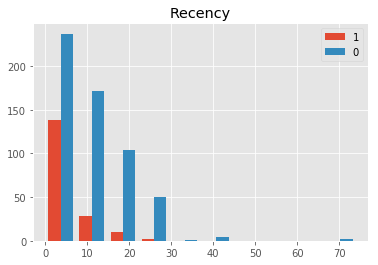

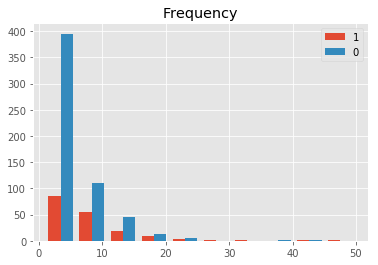

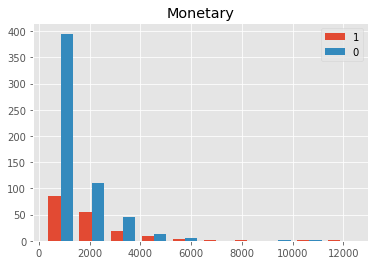

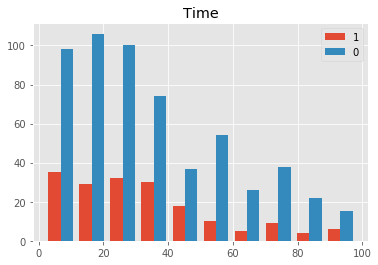

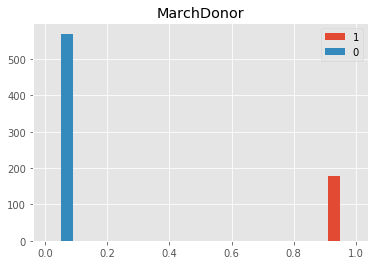

In [11]:
for column in dataset:  
    plt.title(column)
    plt.hist([dataset[dataset['MarchDonor'] == 1][column], dataset[dataset['MarchDonor'] == 0][column]], label=['1', '0'])
    plt.legend(loc='upper right')
    plt.show()

Visualizar los datos y sus clases por pares de atributos mostrando también la clase con color.

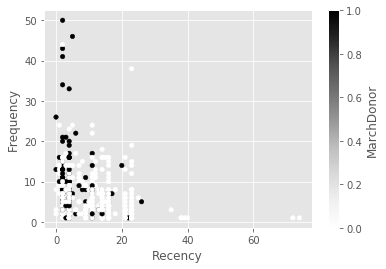

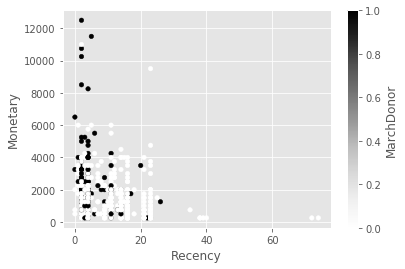

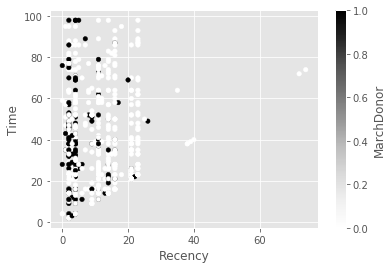

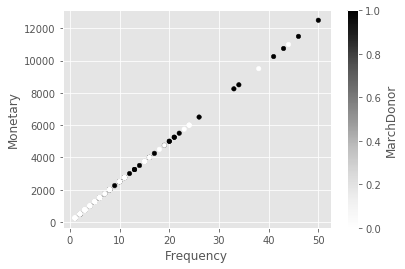

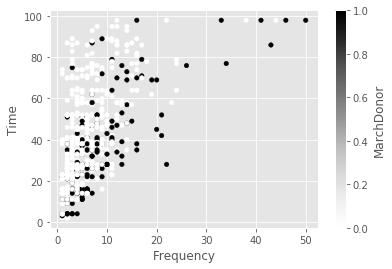

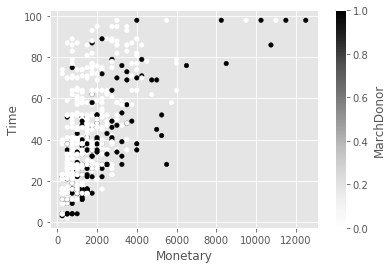

In [12]:
column_names = dataset.columns[:-1]  
for i, columna_i in enumerate(column_names):
    for j, columna_j in enumerate(column_names):
        if i < j:
            fig, ax = plt.subplots()
            dataset.plot.scatter(columna_i, columna_j, c='MarchDonor', ax=ax)

Se ve que hay correlación entre las variables Frequency que representa el número total de donaciones y Monetary - la cantidad total de la sagre donada. Esto tiene sentido. Sin embargo, cuando usamos KNN la correlación entre variables no afecta el modelo por esto trabajaremos con todas las variables de entrada.

### División de los datos en entrenamiento (80%) y test (20%)

Dividimos los datos en entrenamiento y test usando la samilla y estratificamos por la variable de salida MarchDonor para mantener la misma proporción en el conjunto de entrenamiento y en el conjunto de test.

In [13]:
dataset_train, dataset_test = train_test_split(dataset, test_size=0.2, random_state=SEED_VALUE, stratify=dataset["MarchDonor"])
dataset_test

,Recency,Frequency,Monetary,Time,MarchDonor
309,16,3,750,19,0
711,23,6,1500,45,0
343,11,1,250,11,0
462,21,1,250,21,1
646,14,2,500,14,0
722,21,3,750,40,0
740,23,1,250,23,0
568,4,6,1500,35,1
539,2,2,500,4,1
244,9,2,500,11,0


### Separación de variables predictoras y dependientes

Separamos los conjutos de test creando un dataframe para las variables de entrada y un para la de salida.

In [14]:
dataset_train_X = dataset_train.loc[:, "Recency":"Time"].astype(float)
dataset_train_Y = dataset_train.loc[:, "MarchDonor"]

dataset_test_X = dataset_test.loc[:, "Recency":"Time"].astype(float)
dataset_test_Y = dataset_test.loc[:, "MarchDonor"]

dataset_test_X

,Recency,Frequency,Monetary,Time
309,16.0,3.0,750.0,19.0
711,23.0,6.0,1500.0,45.0
343,11.0,1.0,250.0,11.0
462,21.0,1.0,250.0,21.0
646,14.0,2.0,500.0,14.0
722,21.0,3.0,750.0,40.0
740,23.0,1.0,250.0,23.0
568,4.0,6.0,1500.0,35.0
539,2.0,2.0,500.0,4.0
244,9.0,2.0,500.0,11.0


## Estandarización de los datos

Es un problema de clasificación estandarizamos solo las variables de entrada. Usamos el método StandardScaler() y 
calculamos la media y la desviacion sobre el conjunto de entrenamiento

In [15]:
scaler = StandardScaler()

scaler.fit(dataset_train_X)

dataset_train_X_scaled = scaler.transform(dataset_train_X)
dataset_test_X_scaled = scaler.transform(dataset_test_X)

dataset_test_X_scaled

array([[ 8.22450908e-01, -4.47487686e-01, -4.47487686e-01,
        -6.42119939e-01],
       [ 1.70930807e+00,  6.15756676e-02,  6.15756676e-02,
         4.09236507e-01],
       [ 1.88981507e-01, -7.86863255e-01, -7.86863255e-01,
        -9.65614230e-01],
       [ 1.45592031e+00, -7.86863255e-01, -7.86863255e-01,
        -5.61246366e-01],
       [ 5.69063148e-01, -6.17175470e-01, -6.17175470e-01,
        -8.44303871e-01],
       [ 1.45592031e+00, -4.47487686e-01, -4.47487686e-01,
         2.07052575e-01],
       [ 1.70930807e+00, -7.86863255e-01, -7.86863255e-01,
        -4.80372793e-01],
       [-6.97875655e-01,  6.15756676e-02,  6.15756676e-02,
         4.86864317e-03],
       [-9.51263415e-01, -6.17175470e-01, -6.17175470e-01,
        -1.24867173e+00],
       [-6.44062535e-02, -6.17175470e-01, -6.17175470e-01,
        -9.65614230e-01],
       [-6.97875655e-01,  4.00951237e-01,  4.00951237e-01,
        -5.61246366e-01],
       [ 5.69063148e-01, -6.17175470e-01, -6.17175470e-01,
      

Estos son los valores con los que se ha estandarizado.

In [16]:
print("mean [Recency, Frequency, Monetary, Time]: {}  |  std [Recency, Frequency, Monetary, Time]: {}".format(scaler.mean_, scaler.scale_))

mean [Recency, Frequency, Monetary, Time]: [   9.5083612     5.63712375 1409.28093645   34.87959866]  |  std [Recency, Frequency, Monetary, Time]: [   7.89304107    5.89317612 1473.29403119   24.72995729]


### Experimentación de KNN

### Definimos un rango de hiperparámetros para realizar las pruebas

Uso un rango entre 1 y 80 para asegurarme que voy a llegar a los dos extremos - subaprendizaje y sobreapredizaje.

In [17]:
hyperparameters = {'n_neighbors': range(1, 81, 1),
                   'weights': ['uniform', 'distance']} 

### Comenzamos las pruebas con 5-CV

Hacemos validación cruzada.

In [18]:
k_neigh = KNeighborsClassifier()

modelCV = GridSearchCV(k_neigh,
                       hyperparameters,
                       cv=5, 
                       scoring='accuracy',
                       return_train_score=True) 

np.random.seed(SEED_VALUE) 
modelCV.fit(dataset_train_X_scaled, dataset_train_Y)  

/opt/cesga/anaconda/Anaconda2-2018.12/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80], 'weights': ['uniform', 'distance']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

### Resultados obtenidos en 5-CV

Puede verse el ranking de los mejores

In [19]:
cv_results = pd.DataFrame(modelCV.cv_results_)
cv_results.loc[:, ['param_weights', 'param_n_neighbors', 'mean_test_score', 'std_test_score', 'rank_test_score']]

,param_weights,param_n_neighbors,mean_test_score,std_test_score,rank_test_score
0,uniform,1,0.690635,0.043466,159
1,distance,1,0.690635,0.043466,159
2,uniform,2,0.765886,0.025037,73
3,distance,2,0.710702,0.044359,158
4,uniform,3,0.735786,0.028472,155
5,distance,3,0.724080,0.041544,157
6,uniform,4,0.760870,0.029218,99
7,distance,4,0.734114,0.030244,156
8,uniform,5,0.767559,0.024084,67
9,distance,5,0.744147,0.035324,154


Los mejores hiperparámetros en validación serían los siguientes. 

In [20]:
cv_results_best = cv_results[cv_results['rank_test_score'] == 1]
cv_results_best.loc[:, ['param_weights', 'param_n_neighbors', 'mean_test_score', 'std_test_score', 'rank_test_score']]

,param_weights,param_n_neighbors,mean_test_score,std_test_score,rank_test_score
42,uniform,22,0.795987,0.013456,1


Calculamos el error del mejor hiperparámetro:

In [21]:
1 - cv_results_best.loc[:, ['mean_test_score']].values[0]

array([0.20401338])

Calculamos la media + la desviación estándar para ver qué valor vamos a usar para aplicar la regla de One Standard Error 

In [22]:
x = 1 - cv_results_best.loc[:, ['mean_test_score']].values[0] + cv_results_best.loc[:, ['std_test_score']].values[0]
x[0]

0.2174695626306023

### Gráfica de entrenamiento

Hacemos la gráfica de entrenamiento para visualizar el error correspodiente a cada uno de los hiperparámentros. Es este caso decido dejar solo los valores de uniform poorque despues de generar la gráfica por primera vez me di cuenta de que en general con distance el error es mucho más grande en cada uno de los casos y no me serve comparar con estos valores. Además buscamos el modelo más simple y los modelos uniform son más simples.

Aplicamos la regla de un un error estandar hacia la derecha porque el modelo más sencillo. En el caso de KNN los modelos más sencillos son ellos con mayor número de vecinos.

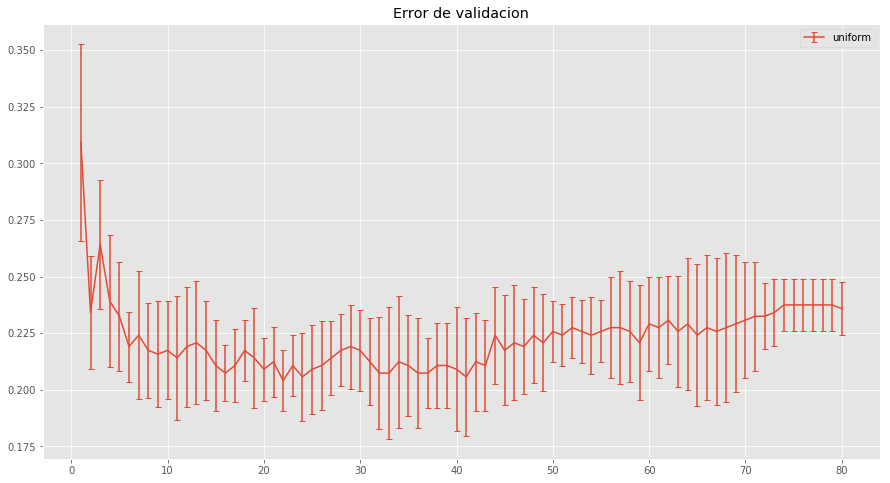

In [23]:
cv_results_uniform = cv_results.loc[cv_results['param_weights'] == "uniform"] 
cv_results_distance = cv_results.loc[cv_results['param_weights'] == "distance"] 

plt.figure(figsize=(15,8))
plt.title("Error de validacion")
plt.errorbar(cv_results_uniform['param_n_neighbors'],1 - cv_results_uniform['mean_test_score'], cv_results_uniform['std_test_score'], label='uniform', capsize=3)  # 1 - [] para imprimir el error
#plt.errorbar(cv_results_distance['param_n_neighbors'],1 - cv_results_distance['mean_test_score'], cv_results_distance['std_test_score'], label='distance', capsize=3)  # 1 - [] para imprimir el error
plt.legend(loc='upper right')
plt.show()

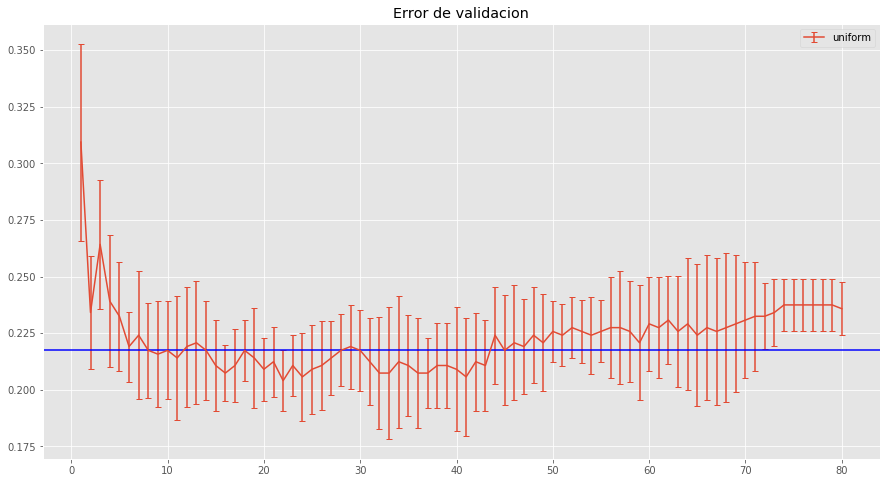

In [24]:
cv_results_uniform = cv_results.loc[cv_results['param_weights'] == "uniform"] 
cv_results_distance = cv_results.loc[cv_results['param_weights'] == "distance"] 

plt.figure(figsize=(15,8))
plt.title("Error de validacion")
plt.errorbar(cv_results_uniform['param_n_neighbors'],1 - cv_results_uniform['mean_test_score'], cv_results_uniform['std_test_score'], label='uniform', capsize=3)  # 1 - [] para imprimir el error
#plt.errorbar(cv_results_distance['param_n_neighbors'],1 - cv_results_distance['mean_test_score'], cv_results_distance['std_test_score'], label='distance', capsize=3)  # 1 - [] para imprimir el error
plt.axhline(y=x[0], color='b', linestyle='-')
plt.legend(loc='upper right')
plt.show()

Buscamos el modelo más simple o sea el con el mayor número de vecinos. En este caso es el 28.

### Creación de un modelo con los mejores hiperparámetros

"Entrenamos" un modelo con el menor error de validación cruzada (`n_neighbors = 28`, `weights = 'uniform'`) y con todo el conjunto de entrenamiento. 

In [25]:
model = KNeighborsClassifier(n_neighbors = 28, weights = 'uniform', algorithm='brute')

np.random.seed(SEED_VALUE)  
model.fit(dataset_train_X_scaled, dataset_train_Y)

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=28, p=2,
           weights='uniform')

### Evaluación del modelo en el conjunto de test

Después de "entrenar" el modelo con todo el conjunto de entrenamiento ya los podemos aplicar al conjunto de test. Guardamos la predicción del modelo en la variable Z.

In [26]:
np.random.seed(SEED_VALUE)
Z = model.predict(dataset_test_X_scaled)

Hacemos una comparación entre las predicciones en Z y los valores reales.

In [27]:
accuracy_test = accuracy_score(dataset_test_Y, Z) 
print("Accuracy en test: {}  |  Error en test: {}".format(accuracy_test, 1-accuracy_test))

Accuracy en test: 0.786666666667  |  Error en test: 0.213333333333


### Verificación de nuestros hiperparámetros

Hacemos un Grid Search utilizando el conjunto de entrenamiento al completo y nuestro conjunto de validación va a ser el conjunto de test.

In [28]:
# Creamos una lista con `-1` para los índices de entrenamiento y `0` para los índices de validación
split_test_fold = [-1]*len(dataset_train_Y) + [0]*len(dataset_test_Y)
ps = PredefinedSplit(test_fold=split_test_fold) #divicion de datos

# Juntamos los conjuntos de entrenamiento y test, fingiendo que son un sólo conjunto de entrenamiento-validación
dataset_all_X_scaled = np.vstack([dataset_train_X_scaled, dataset_test_X_scaled])
dataset_all_Y = pd.concat([dataset_train_Y, dataset_test_Y]) 

k_neigh = KNeighborsClassifier()
modelCV = GridSearchCV(k_neigh,
                       hyperparameters,
                       cv=ps, 
                       scoring='accuracy',
                       return_train_score=True)

np.random.seed(SEED_VALUE) 
modelCV.fit(dataset_all_X_scaled, dataset_all_Y)

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
       error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80], 'weights': ['uniform', 'distance']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

Obtenemos los resultados de la validación con el conjunto de test.

In [29]:
test_results = pd.DataFrame(modelCV.cv_results_)
test_results.loc[:, ['param_weights', 'param_n_neighbors', 'mean_test_score', 'rank_test_score']]

,param_weights,param_n_neighbors,mean_test_score,rank_test_score
0,uniform,1,0.680000,159
1,distance,1,0.680000,159
2,uniform,2,0.773333,108
3,distance,2,0.700000,158
4,uniform,3,0.766667,134
5,distance,3,0.753333,154
6,uniform,4,0.773333,108
7,distance,4,0.753333,154
8,uniform,5,0.786667,58
9,distance,5,0.780000,85


Vizualizamos el error en el conjunto de entrenamiento y también el error en el conjunto de test para ver si nuestro modelo ha hecho buen trabajo.

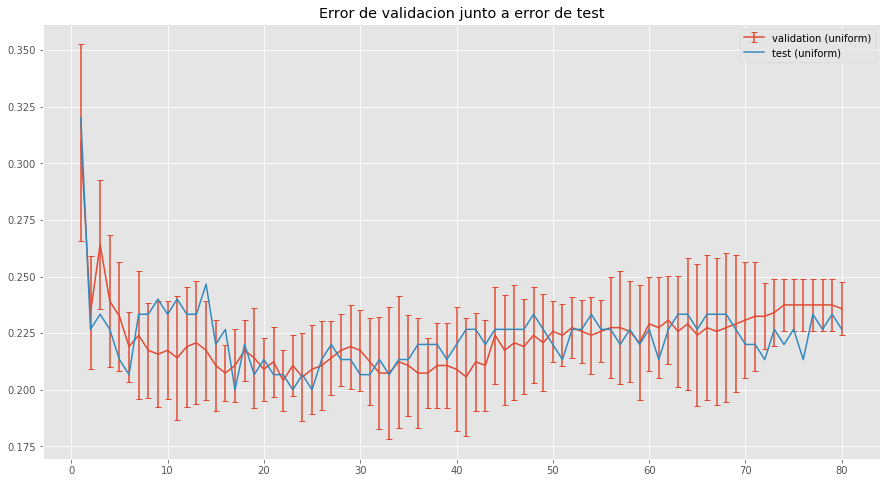

In [30]:
plt.figure(figsize=(15,8))
plt.title("Error de validacion junto a error de test")

cv_results_uniform = cv_results[cv_results['param_weights'] == 'uniform']
cv_results_distance = cv_results[cv_results['param_weights'] == 'distance']

test_results_uniform = test_results[test_results['param_weights'] == 'uniform']  # Lo vamos a limitar a `weights = 'uniform'`
test_results_distance = test_results[test_results['param_weights'] == 'distance']  # Lo vamos a limitar a `weights = 'uniform'`

plt.errorbar(cv_results_uniform['param_n_neighbors'],1 - cv_results_uniform['mean_test_score'], cv_results_uniform['std_test_score'], label='validation (uniform)', capsize=3)  # 1 - [] para imprimir el error
# plt.errorbar(cv_results_distance['param_n_neighbors'],1 - cv_results_distance['mean_test_score'], cv_results_distance['std_test_score'], label='validation (distance)', capsize=3)  # 1 - [] para imprimir el error

plt.errorbar(test_results_uniform['param_n_neighbors'],1 - test_results_uniform['mean_test_score'], label='test (uniform)', capsize=3)  # 1 - [] para imprimir el error
# plt.errorbar(test_results_distance['param_n_neighbors'],1 - test_results_distance['mean_test_score'], label='test (distance)', capsize=3)  # 1 - [] para imprimir el error

plt.legend(loc='upper right')
plt.show()


Parece que el menor error de test se obtendría con 17 vecinos y con otros, sin embargo con el hiperpárametro que hemos elegido también consigue un nivel del error pequeño.

## Ejercicio 2: Regresión - Energy Efficiency

In [31]:
DATASET_NAME = 'EnergyEfficiency.data'
DATASET_DELIMITER = ','

### Leemos el fichero de datos

In [32]:
dataset = pd.read_csv(DATASET_NAME, 
                      delimiter=DATASET_DELIMITER,
                      skiprows=1,
                      names = ["X1", "X2", "X3", "X4", "X5","X6","X7","X8","Y2"])
dataset

,X1,X2,X3,X4,X5,X6,X7,X8,Y2
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,28.28
5,0.90,563.5,318.5,122.50,7.0,3,0.0,0,25.38
6,0.90,563.5,318.5,122.50,7.0,4,0.0,0,25.16
7,0.90,563.5,318.5,122.50,7.0,5,0.0,0,29.60
8,0.86,588.0,294.0,147.00,7.0,2,0.0,0,27.30
9,0.86,588.0,294.0,147.00,7.0,3,0.0,0,21.97


El fichero contiene 9 variables y 758 observaciones distintas. Las variables predictoras son 8 en total nombradas de `X0` a `X8`, y la variable dependiente sería `Y2`. Estamos ante un problema de regresión ya que la variable de salida es una variable continua.

### Visualizamos los datos

También podemos visualizar los datos y sus clases por pares de atributos:

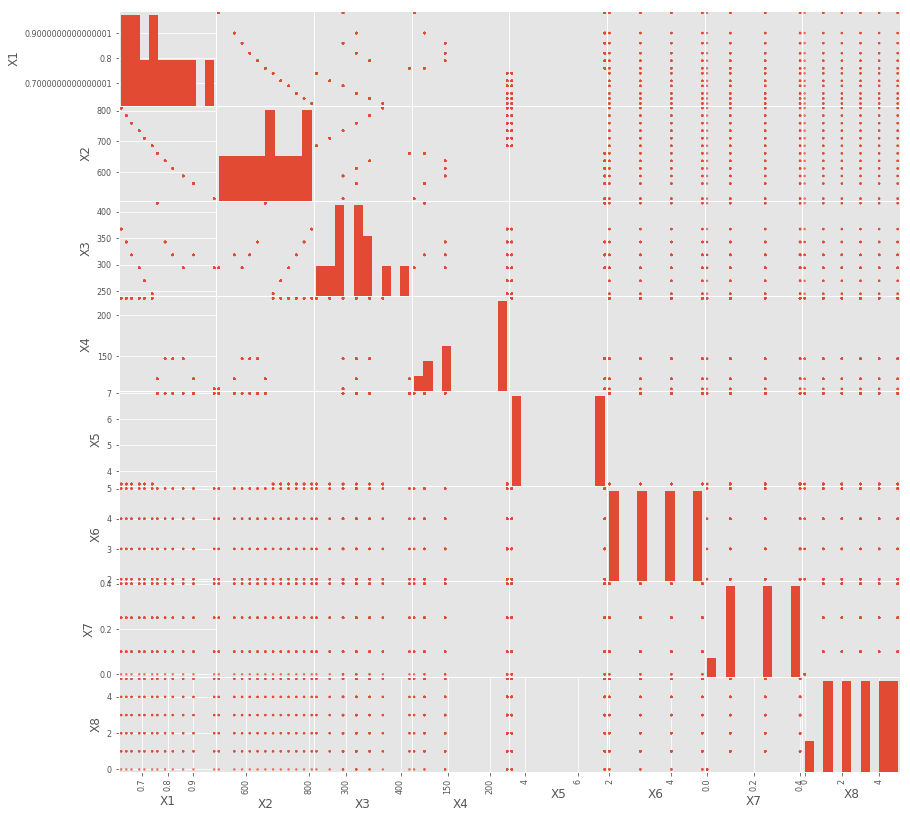

In [33]:
axes = pd.plotting.scatter_matrix(dataset.loc[:, dataset.columns != 'Y2'], alpha=0.3, figsize=(14,14), s=20)

#for i in range(np.shape(axes)[0]):
#    for j in range(np.shape(axes)[1]):
#        if i <= j:
#            axes[i,j].set_visible(False)

### División de los datos en entrenamiento (80%) y test (20%):

In [34]:
dataset_train, dataset_test = train_test_split(dataset, test_size=0.2, random_state=SEED_VALUE, stratify=None)
dataset_test

,X1,X2,X3,X4,X5,X6,X7,X8,Y2
285,0.62,808.5,367.5,220.50,3.5,3,0.10,5,13.97
101,0.90,563.5,318.5,122.50,7.0,3,0.10,2,29.44
581,0.90,563.5,318.5,122.50,7.0,3,0.40,2,35.39
352,0.79,637.0,343.0,147.00,7.0,2,0.25,2,43.86
726,0.90,563.5,318.5,122.50,7.0,4,0.40,5,38.79
472,0.64,784.0,343.0,220.50,3.5,2,0.25,4,19.65
233,0.64,784.0,343.0,220.50,3.5,3,0.10,4,19.25
385,0.98,514.5,294.0,110.25,7.0,3,0.25,3,29.78
556,0.71,710.5,269.5,220.50,3.5,2,0.40,1,17.10
59,0.86,588.0,294.0,147.00,7.0,5,0.10,1,31.73


### Separación de variables predictoras y dependientes

In [35]:
dataset_train_X = dataset_train.loc[:, "X1":"X8"].astype(float)
dataset_train_Y = dataset_train.loc[:, ["Y2"]].astype(float)

dataset_test_X = dataset_test.loc[:, "X1":"X8"].astype(float)
dataset_test_Y = dataset_test.loc[:, ["Y2"]].astype(float)

dataset_test_X

,X1,X2,X3,X4,X5,X6,X7,X8
285,0.62,808.5,367.5,220.50,3.5,3.0,0.10,5.0
101,0.90,563.5,318.5,122.50,7.0,3.0,0.10,2.0
581,0.90,563.5,318.5,122.50,7.0,3.0,0.40,2.0
352,0.79,637.0,343.0,147.00,7.0,2.0,0.25,2.0
726,0.90,563.5,318.5,122.50,7.0,4.0,0.40,5.0
472,0.64,784.0,343.0,220.50,3.5,2.0,0.25,4.0
233,0.64,784.0,343.0,220.50,3.5,3.0,0.10,4.0
385,0.98,514.5,294.0,110.25,7.0,3.0,0.25,3.0
556,0.71,710.5,269.5,220.50,3.5,2.0,0.40,1.0
59,0.86,588.0,294.0,147.00,7.0,5.0,0.10,1.0


### Estandarización de los datos

Primero estandarizamos las variables de entrada.

In [36]:
scaler = StandardScaler()

#calculamos la media y la desviacion sobre el conjunto de entrenamiento, no sobre todo el conjunto
scaler.fit(dataset_train_X)

#las dos estandarizamos con la media y sd del entremanieto (el mismo scaler para los dos)
dataset_train_X_scaled = scaler.transform(dataset_train_X)
dataset_test_X_scaled = scaler.transform(dataset_test_X)

dataset_test_X_scaled
#en problemas de regresion lo tenemos que hacer tambien para la vatiable de salida

array([[-1.33525558,  1.52364121,  1.12278518, ..., -0.42346954,
        -0.99633936,  1.40105783],
       [ 1.28346607, -1.23517832,  0.00816901, ..., -0.42346954,
        -0.99633936, -0.54374136],
       [ 1.28346607, -1.23517832,  0.00816901, ..., -0.42346954,
         1.26941014, -0.54374136],
       ...,
       [ 0.90936298, -0.95929637, -0.54913907, ...,  0.47003664,
        -0.99633936,  0.10452504],
       [ 0.53525988, -0.68341441,  0.00816901, ..., -1.31697573,
         1.26941014,  0.75279143],
       [ 0.25468256, -0.40753246,  0.56547709, ...,  1.36354282,
         1.26941014,  0.10452504]])

Estos son los valores con los que se ha estandarizado.

In [37]:
print("mean [X1,X2,X3,X4,X5,X6,X7,X8]: {}  |  std [X1,X2,X3,X4,X5,X6,X7,X8]: {}".format(scaler.mean_, scaler.scale_))

mean [X1,X2,X3,X4,X5,X6,X7,X8]: [7.62768730e-01 6.73191368e+02 3.18140879e+02 1.77525244e+02
 5.19869707e+00 3.47394137e+00 2.31921824e-01 2.83876221e+00]  |  std [X1,X2,X3,X4,X5,X6,X7,X8]: [ 0.1069224  88.80609907 43.96132191 45.46444155  1.74924784  1.11918644
  0.13240652  1.54257571]


Después estandarizamos la variable de salida porque es un problem de regresión.

In [38]:
scaler_y = StandardScaler()

#calculamos la media y la desviacion sobre el conjunto de entrenamiento, no sobre todo el conjunto
scaler_y.fit(dataset_train_Y)

#las dos estandarizamos con la media y sd del entremanieto (el mismo scaler para los dos)
dataset_train_Y_scaled = scaler_y.transform(dataset_train_Y)
dataset_test_Y_scaled = scaler_y.transform(dataset_test_Y)

dataset_test_Y_scaled
#en problemas de regresion lo tenemos que hacer tambien para la vatiable de salida

array([[-1.09538181],
       [ 0.54110007],
       [ 1.17051617],
       [ 2.06650851],
       [ 1.53018252],
       [-0.49452744],
       [-0.53684113],
       [ 0.5770667 ],
       [-0.7642772 ],
       [ 0.78334593],
       [-0.70715372],
       [ 0.87960957],
       [ 0.54004222],
       [-0.63098909],
       [-0.88169769],
       [ 2.28971321],
       [ 1.59894226],
       [-0.64368319],
       [-0.99806033],
       [ 1.030881  ],
       [ 0.18566509],
       [-1.17577782],
       [ 0.06401324],
       [-0.29565311],
       [-0.74840957],
       [ 1.36833266],
       [-0.73677331],
       [-1.0625887 ],
       [ 2.33943179],
       [-0.95151527],
       [ 0.93144383],
       [ 1.27524255],
       [-0.98642406],
       [-0.89439179],
       [ 0.7124705 ],
       [ 2.46108365],
       [-0.37075991],
       [-1.12182786],
       [ 1.32707682],
       [-0.76216152],
       [ 1.30063076],
       [-1.00652306],
       [-1.29954535],
       [-0.53260976],
       [-1.06153086],
       [-0

In [39]:
print("mean [Y2]: {}  |  std [Y2]: {}".format(scaler_y.mean_, scaler_y.scale_))

mean [Y2]: [24.32486971]  |  std [Y2]: [9.45320583]


### Empezamos con la experimentación de KNN

### Definimos un rango de hiperparámetros para realizar las pruebas

In [40]:
hyperparameters = {'n_neighbors': range(1, 51, 1), 
                   'weights': ['uniform', 'distance']}

### Comenzamos las pruebas con 5-CV

In [41]:
k_neigh = KNeighborsRegressor()

modelCV = GridSearchCV(k_neigh,
                       hyperparameters,
                       cv=5, 
                       scoring='neg_mean_squared_error',
                       return_train_score=True)  

np.random.seed(SEED_VALUE)  
modelCV.fit(dataset_train_X_scaled, dataset_train_Y_scaled)  

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=5, p=2,
          weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50], 'weights': ['uniform', 'distance']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

### Resultados obtenidos en 5-CV

Podemos ver el ranking de los mejores hiperparámetros.

In [42]:
cv_results = pd.DataFrame(modelCV.cv_results_)
cv_results.loc[:, ['param_weights', 'param_n_neighbors', 'mean_test_score', 'std_test_score', 'rank_test_score']]

,param_weights,param_n_neighbors,mean_test_score,std_test_score,rank_test_score
0,uniform,1,-0.094646,0.019395,35
1,distance,1,-0.094646,0.019395,35
2,uniform,2,-0.068437,0.006468,1
3,distance,2,-0.068488,0.005658,2
4,uniform,3,-0.075310,0.003948,5
5,distance,3,-0.073690,0.004670,3
6,uniform,4,-0.078032,0.006058,6
7,distance,4,-0.074811,0.005558,4
8,uniform,5,-0.085094,0.006366,15
9,distance,5,-0.080100,0.005328,9


Los mejores hiperparámetros en validación sería el siguiente: el número de vecinos 2.

In [43]:
cv_results_best = cv_results[cv_results['rank_test_score'] == 1]
cv_results_best.loc[:, ['param_weights', 'param_n_neighbors', 'mean_test_score', 'std_test_score', 'rank_test_score']]

,param_weights,param_n_neighbors,mean_test_score,std_test_score,rank_test_score
2,uniform,2,-0.068437,0.006468,1


Estandarizamos el error multiplicando por la varianza de Y.

In [44]:
cv_results['mean_test_score'] = cv_results['mean_test_score'] *((scaler_y.scale_)**2)
cv_results['std_test_score'] = cv_results['std_test_score'] *((scaler_y.scale_)**2)

In [45]:
cv_results_best = cv_results[cv_results['rank_test_score'] == 1]
cv_results_best.loc[:, ['param_weights', 'param_n_neighbors', 'mean_test_score', 'std_test_score', 'rank_test_score']]

,param_weights,param_n_neighbors,mean_test_score,std_test_score,rank_test_score
2,uniform,2,-6.115758,0.577994,1


### Gráfica de entrenamiento

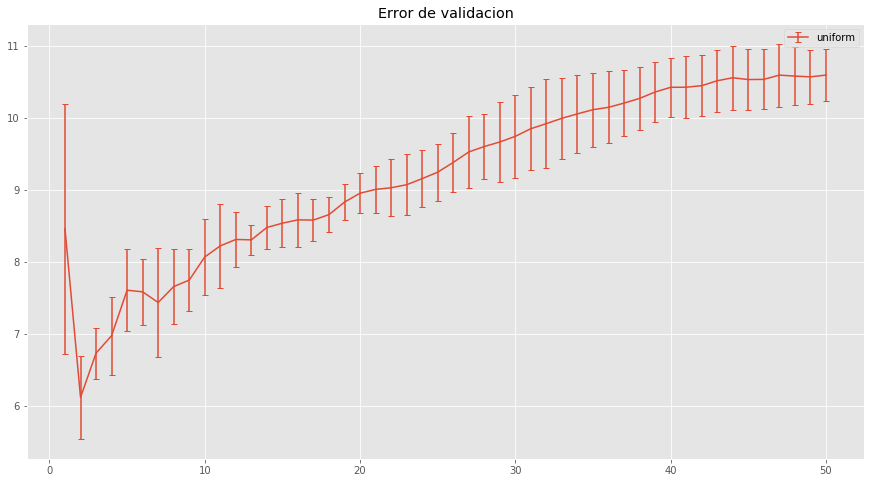

In [46]:
cv_results_uniform = cv_results.loc[cv_results['param_weights'] == "uniform"] #separa los datos solo uniforme
cv_results_distance = cv_results.loc[cv_results['param_weights'] == "distance"] #solo disrancia

plt.figure(figsize=(15,8))
plt.title("Error de validacion")
plt.errorbar(cv_results_uniform['param_n_neighbors'],-cv_results_uniform['mean_test_score'], cv_results_uniform['std_test_score'], label='uniform', capsize=3)  # 1 - [] para imprimir el error
#plt.errorbar(cv_results_distance['param_n_neighbors'],-cv_results_distance['mean_test_score'], cv_results_distance['std_test_score'], label='distance', capsize=3)  # 1 - [] para imprimir el error
plt.legend(loc='upper right')
plt.show()

In [47]:
x = -cv_results_best.loc[:, ['mean_test_score']].values[0] + cv_results_best.loc[:, ['std_test_score']].values[0]
x[0]

6.693751955325673

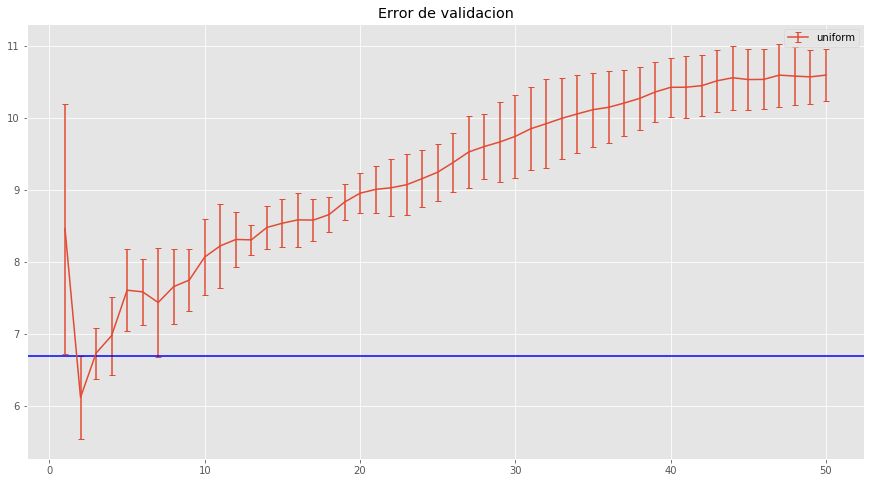

In [48]:
cv_results_uniform = cv_results.loc[cv_results['param_weights'] == "uniform"] #separa los datos solo uniforme
cv_results_distance = cv_results.loc[cv_results['param_weights'] == "distance"] #solo disrancia

plt.figure(figsize=(15,8))
plt.title("Error de validacion")
plt.errorbar(cv_results_uniform['param_n_neighbors'],-cv_results_uniform['mean_test_score'], cv_results_uniform['std_test_score'], label='uniform', capsize=3)  # 1 - [] para imprimir el error
#plt.errorbar(cv_results_distance['param_n_neighbors'],-cv_results_distance['mean_test_score'], cv_results_distance['std_test_score'], label='distance', capsize=3)  # 1 - [] para imprimir el error
plt.axhline(y=x[0], color='b', linestyle='-')
plt.legend(loc='upper right')
plt.show()

Después de aplicar la regla One Standard Error vemos que el mejor hiperpárametro no cambia. Nos quedamos con número de vecinos igual a 2.

## Creación de un modelo con los mejores hiperparámetros

"Entrenamos" un modelo con el menor error de validación cruzada (`n_neighbors = 2`, `weights = 'uniform'`) y con todo el conjunto de entrenamiento.

In [49]:
model = KNeighborsRegressor(n_neighbors = 2, weights = 'uniform', algorithm='brute')

np.random.seed(SEED_VALUE) 
model.fit(dataset_train_X_scaled, dataset_train_Y_scaled)


KNeighborsRegressor(algorithm='brute', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=2, p=2,
          weights='uniform')

## Evaluación del modelo en el conjunto de test

In [50]:
np.random.seed(SEED_VALUE)
Z = model.predict(dataset_test_X_scaled)

In [51]:
mean_squared_error_test = mean_squared_error(dataset_test_Y_scaled, Z)* ((scaler_y.scale_)**2)
print("Error en test: {}".format(mean_squared_error_test))

Error en test: [12.59493653]


## Verificación de nuestros hiperparámetros

Hacemos un Grid Search utilizando el conjunto de entrenamiento al completo (80% de los datos) y nuestro conjunto de validación va a ser el conjunto de test (20% de los datos).

In [52]:
# Creamos una lista con `-1` para los índices de entrenamiento y `0` para los índices de validación
split_test_fold = [-1]*len(dataset_train_Y_scaled) + [0]*len(dataset_test_Y_scaled)
ps = PredefinedSplit(test_fold=split_test_fold) #divicion de datos

# Juntamos los conjuntos de entrenamiento y test, fingiendo que son un sólo conjunto de entrenamiento-validación
dataset_all_X_scaled = np.vstack([dataset_train_X_scaled, dataset_test_X_scaled])
dataset_all_Y_scaled = np.vstack([dataset_train_Y_scaled, dataset_test_Y_scaled]) 

k_neigh = KNeighborsRegressor()
modelCV = GridSearchCV(k_neigh,
                       hyperparameters,
                       cv=ps, #los que estaban en test los usara para validacion, los de validacion para entrenamiento?
                       scoring='neg_mean_squared_error',
                       return_train_score=True)

np.random.seed(SEED_VALUE)  # Por como funciona KNN, no haría falta establecer semilla. Pero lo ponemos igualmente
modelCV.fit(dataset_all_X_scaled, dataset_all_Y_scaled)


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
       error_score='raise-deprecating',
       estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=5, p=2,
          weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50], 'weights': ['uniform', 'distance']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [53]:
test_results = pd.DataFrame(modelCV.cv_results_)
test_results.loc[:, ['param_weights', 'param_n_neighbors', 'mean_test_score', 'rank_test_score']]

,param_weights,param_n_neighbors,mean_test_score,rank_test_score
0,uniform,1,-0.174802,99
1,distance,1,-0.174802,99
2,uniform,2,-0.140871,61
3,distance,2,-0.144015,72
4,uniform,3,-0.111449,10
5,distance,3,-0.116664,19
6,uniform,4,-0.125582,29
7,distance,4,-0.127082,33
8,uniform,5,-0.129534,39
9,distance,5,-0.129595,41


In [54]:
test_results['mean_test_score'] = test_results['mean_test_score']*((scaler_y.scale_)**2)
test_results.loc[:, ['param_weights', 'param_n_neighbors', 'mean_test_score', 'rank_test_score']]

,param_weights,param_n_neighbors,mean_test_score,rank_test_score
0,uniform,1,-15.620854,99
1,distance,1,-15.620854,99
2,uniform,2,-12.588656,61
3,distance,2,-12.869604,72
4,uniform,3,-9.959396,10
5,distance,3,-10.425490,19
6,uniform,4,-11.222376,29
7,distance,4,-11.356457,33
8,uniform,5,-11.575521,39
9,distance,5,-11.580985,41


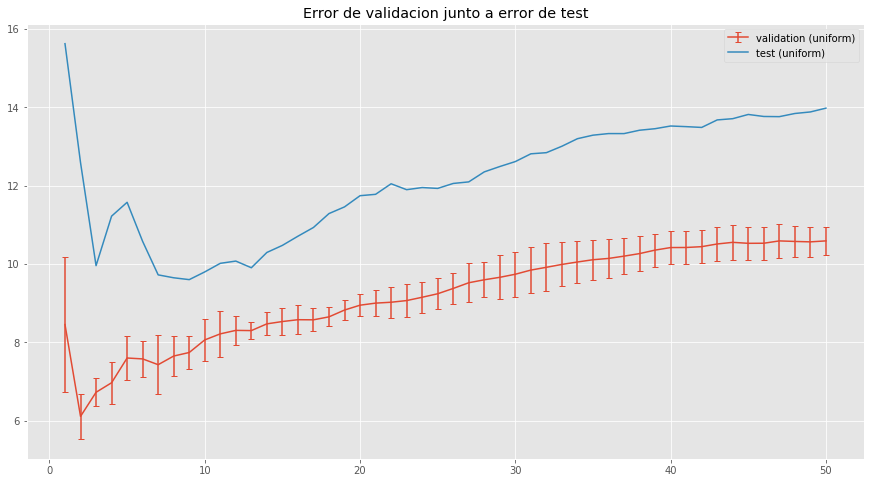

In [56]:
plt.figure(figsize=(15,8))
plt.title("Error de validacion junto a error de test")

cv_results_uniform = cv_results[cv_results['param_weights'] == 'uniform']
cv_results_distance = cv_results[cv_results['param_weights'] == 'distance']

test_results_uniform = test_results[test_results['param_weights'] == 'uniform']  # Lo vamos a limitar a `weights = 'uniform'`
test_results_distance = test_results[test_results['param_weights'] == 'distance']  # Lo vamos a limitar a `weights = 'uniform'`

plt.errorbar(cv_results_uniform['param_n_neighbors'],-cv_results_uniform['mean_test_score'], cv_results_uniform['std_test_score'], label='validation (uniform)', capsize=3)  # 1 - [] para imprimir el error
# plt.errorbar(cv_results_distance['param_n_neighbors'],1 - cv_results_distance['mean_test_score'], cv_results_distance['std_test_score'], label='validation (distance)', capsize=3)  # 1 - [] para imprimir el error

plt.errorbar(test_results_uniform['param_n_neighbors'],-test_results_uniform['mean_test_score'], label='test (uniform)', capsize=3)  # 1 - [] para imprimir el error
# plt.errorbar(test_results_distance['param_n_neighbors'],1 - test_results_distance['mean_test_score'], label='test (distance)', capsize=3)  # 1 - [] para imprimir el error

plt.legend(loc='upper right')
plt.show()

#la de validacion en en rojo, pero no es validacion cruzada, es la validacion original que teniamos

Parece que el menor error de test se obtendría con 9 vecinos.